## Setup

In [1]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

## Vectorize an example sentence

In [3]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split())
print(len(tokens))

8


In [4]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for token in tokens:
    if token not in vocab:
        vocab[token] = index
        index += 1
vocab_size = len(vocab)
print(vocab)

{'<pad>': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}


In [5]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: '<pad>', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}


In [6]:
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[1, 2, 3, 4, 5, 1, 6, 7]


## Generate skip-grams from one sentence

In [7]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
    example_sequence,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=0)
print(len(positive_skip_grams))

26


In [8]:
for target, context in positive_skip_grams[:5]:
    print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

(3, 4): (road, shimmered)
(4, 2): (shimmered, wide)
(2, 3): (wide, road)
(2, 1): (wide, the)
(4, 5): (shimmered, in)


## Negative sampling for one skip-gram

In [9]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=SEED,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

tf.Tensor([2 1 4 3], shape=(4,), dtype=int64)
['wide', 'the', 'shimmered', 'road']


## Construct one training example

In [10]:
# Reduce a dimension so you can use concatenation (in the next step).
squeezed_context_class = tf.squeeze(context_class, 1)

# Concatenate a positive context word with negative sampled words.
context = tf.concat([squeezed_context_class, negative_sampling_candidates], 0)

# Label the first context word as `1` (positive) followed by `num_ns` `0`s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64")
target = target_word

In [11]:
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 3
target_word     : road
context_indices : [4 2 1 4 3]
context_words   : ['shimmered', 'wide', 'the', 'shimmered', 'road']
label           : [1 0 0 0 0]


In [12]:
print("target  :", target)
print("context :", context)
print("label   :", label)

target  : 3
context : tf.Tensor([4 2 1 4 3], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


## Summary
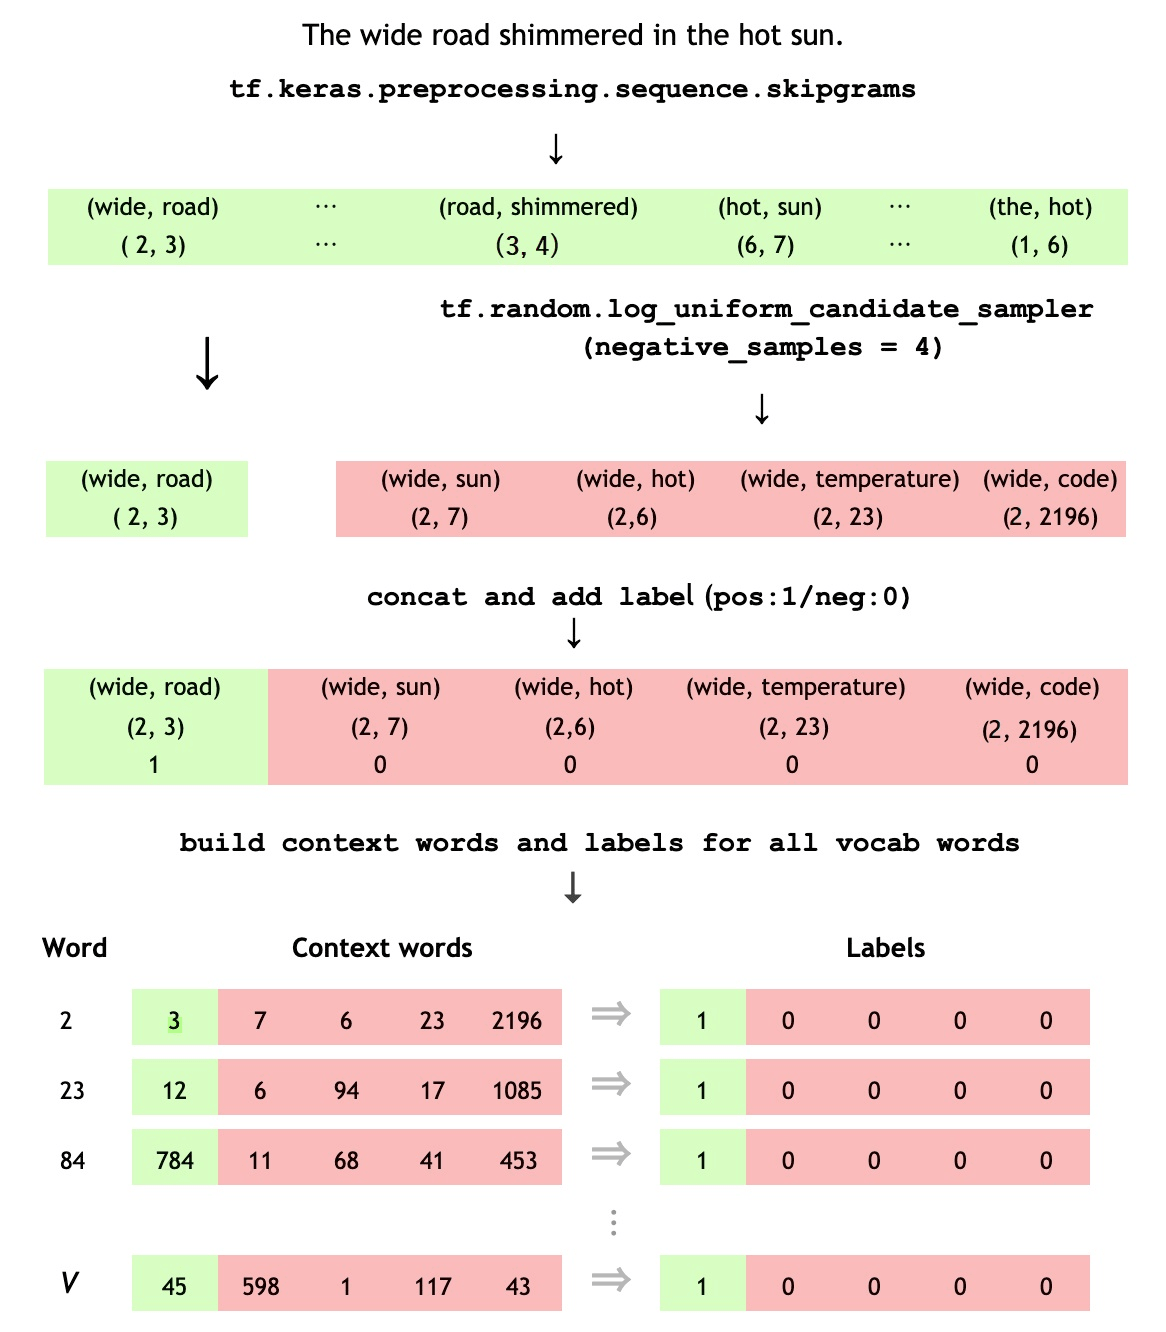

## Compile all steps into one function
### Skip-gram sampling table

In [13]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


## Generate training data

In [14]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(
            tf.constant([context_word], dtype="int64"), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=context_class,
            num_true=1,
            num_sampled=num_ns,
            unique=True,
            range_max=vocab_size,
            seed=seed,
            name="negative_sampling")

        # Build context and label vectors (for one target word)
        context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
        label = tf.constant([1] + [0]*num_ns, dtype="int64")

        # Append each element from the training example to global lists.
        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

    return targets, contexts, labels

## Prepare training data for word2vec

### Download text corpus

In [15]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 2s 1us/step


In [16]:
with open(path_to_file) as f:
    lines = f.read().splitlines()
for line in lines[:20]:
    print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


In [17]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

### Vectorize sentences from the corpus

In [18]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [19]:
vectorize_layer.adapt(text_ds.batch(1024))

In [20]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your']


In [21]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

### Obtain sequences from the dataset

In [22]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

32777


In [23]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] => ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']


### Generate training examples from sequences

In [24]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|█████████████████████████| 32777/32777 [00:57<00:00, 570.77it/s]




targets.shape: (65333,)
contexts.shape: (65333, 5)
labels.shape: (65333, 5)


### Configure the dataset for performance

In [25]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [26]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


## Model and training

In [27]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
                                                 embedding_dim,
                                                 input_length=1,
                                                 name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                                  embedding_dim,
                                                  input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [28]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [29]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [30]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
63/63 [==============================] - 3s 21ms/step - loss: 1.6082 - accuracy: 0.2347
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 1.5888 - accuracy: 0.5518
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 1.5409 - accuracy: 0.6001
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 1.4579 - accuracy: 0.5755
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 1.3596 - accuracy: 0.5816
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 1.2628 - accuracy: 0.6086
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 1.1727 - accuracy: 0.6407
Epoch 8/20
63/63 [==============================] - 1s 18ms/step - loss: 1.0894 - accuracy: 0.6754
Epoch 9/20
63/63 [==============================] - 1s 19ms/step - loss: 1.0119 - accuracy: 0.7086
Epoch 10/20
63/63 [==============================] - 1s 18ms/step - loss: 0.9400 - accuracy: 0.7384
Epoch 11/

## Embedding lookup and analysis

In [31]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [32]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [33]:
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception:
    pass